In [ ]:
# LOAD PACKAGES 
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import scipy.stats as stats
# import pingouin as pg
# For prfpy 
from prfpy.stimulus import *
from prfpy.model import Iso2DGaussianModel,Norm_Iso2DGaussianModel
# For dag_prf_utils
from dag_prf_utils.prfpy_functions import * #Prf1T1M, PrfMulti 
from dag_prf_utils.prfpy_ts_plotter import TSPlotter
from dag_prf_utils.plot_functions import * 
# SCOTOMA PROJECT 
from artscot_JOV.load_saved_info import *
from artscot_JOV.plot_functions import *

# Fix seed (just in case doing anything random)
np.random.seed(0)


: 

In [ ]:
# SAVE NOTEBOOK + FIGURES
from figure_finder.figure_saver import FigureSaver
nb_output = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline'
if not os.path.exists(nb_output):
    os.mkdir(nb_output)

fig_saver = FigureSaver(
    name='scot_MAIN-2025-05-12',
    path=nb_output,
    fig_overwrite='ow',   
    save_mode       = True, 
    save_svg        = True,
    save_svg_w_code = False,
    save_png        = True,
    save_pdf        = True,
    folder_ow       = True,
)
fig_saver.save_running_code()
as_cols = {
    'AS0'   : '#000000',
    'AS1'   : '#d95f02',
    'AS2'   : '#7570b3',
}

# Load subjects - sped up by multiprocessing
ecc_bins = np.linspace(0,5,6)
# More IP plotting functions

mod_cols = {
    'gauss' : '#3CA969',
    'G' : '#3CA969',
    'norm' :  '#8557A7',
    'N' :  '#8557A7',
}

Making folder


<IPython.core.display.Javascript object>

jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r00_scot_main-2024-11-15.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_MAIN-2025-05-12/r00_scot_main-2024-11-15.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r00_scot_main-2024-11-15.ipynb to html
[NbConvertApp] Writing 689954 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_MAIN-2025-05-12/r00_scot_main-2024-11-15.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r00_scot_main-2024-11-15.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_MAIN-2025-05-12/r00_scot_main-2024-11-15_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r00_scot_main-2024-11-15.ipynb to html
[NbConvertApp] Writing 563161 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_MAIN-2025-05-12/r00_scot_main-2024-11-15_NOCODE.html


## LOAD

#### Where and what to load

In [3]:
task_list = {}
task_list['full'] = ['AS0', 'AS1', 'AS2']
look_in = {}
look_in['full'] = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf'

model_list = ['gauss' , 'norm']
sub_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07'] 

roi_fit = 'all'

roi_list = ['all', 'v1custom', 'v2custom', 'v3custom', 'v3abcustom', 'v4custom', 'LOcustom', 'TOcustom', 'IPScustom']
# SIMPLIFIED VERSION:
upsampling_factor = 1.7**2 / 0.7**2
print(f'Upsampling factor: {upsampling_factor}')



Upsampling factor: 5.8979591836734695


#### Load stimuli

In [4]:
scotoma_info = get_scotoma_info(sub_list[0])
dm_npy = get_design_matrix_npy(['AS0', 'AS1', 'AS2'])
fit_settings = load_data_prf(
    sub_list[0], 'AS0', 'gauss', var_to_load='settings',
    look_in=look_in['full'], 
    )['AS0']['gauss']
prfpy_stim = {}
prfpy_mod = {'gauss':{}, 'norm':{}}
cut_vols = 5
for stim in dm_npy.keys():
    prfpy_stim[stim] = PRFStimulus2D(
        screen_size_cm=fit_settings['screen_size_cm'],
        screen_distance_cm=fit_settings['screen_distance_cm'],
        design_matrix=dm_npy[stim][:,:,cut_vols:], 
        axis=0,
        TR=fit_settings['TR']
        )
    prfpy_mod['gauss'][stim] = Iso2DGaussianModel(prfpy_stim[stim])
    prfpy_mod['norm'][stim] = Norm_Iso2DGaussianModel(prfpy_stim[stim])



/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl


In [5]:
def simplify_prf_names(prf_name):
    prf_out = prf_name.replace('gauss', 'G')
    prf_out = prf_out.replace('norm', 'N')
    prf_out = prf_out.replace('_', 'f_') # for full
    return prf_out


#### Load the full fits

In [6]:
fit_version = 'full'
prf_obj = {}
for sub in sub_list:
    real_tc = load_data_tc(
        sub=sub, 
        task_list=task_list[fit_version], 
        look_in=look_in[fit_version]
        )        
    prf_pars = load_data_prf(
        sub=sub,
        task_list=task_list[fit_version],
        look_in=look_in[fit_version], 
        model_list=model_list,
        roi_fit=roi_fit,
        include='tc', 
        )
    prf_obj_list = []
    prf_id_list = []
    for iT,task in enumerate(task_list[fit_version]):    
        dm_task = task.split('_')[0]
        for model in model_list:
            prf_obj_list.append(TSPlotter(
                prf_params = prf_pars[task][model],
                model=model,
                prfpy_model=prfpy_mod[model][dm_task],
                real_ts=real_tc[task],
                ))
            prf_id_list.append(
                simplify_prf_names(f'{task}_{model}'))
    prf_obj[sub] = PrfMulti(
        prf_obj_list, 
        prf_id_list,
        )

/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-norm_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS1-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-norm_roi-all_task-AS1-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS2-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:297: RuntimeWarning: invalid value encountered in divide
  self.params_dd['size_ratio'] = self.params_dd['size_2'] / self.params_dd['size_1']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:298: RuntimeWarning: invalid value encountered in divide
  self.params_dd['amp_ratio'] = self.params_dd['amp_2'] / self.params_dd['amp_1']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:300: RuntimeWarning: invalid value encountered in divide
  self.params_dd['bd_ratio'] = self.params_dd['b_val'] / self.params_dd['d_val']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:302: RuntimeWarning: invalid value encountered in divide
  self.params_dd['sup_idx'] = (self.params_dd['amp_1'] * self.params_dd['size_1']**2) / (self.params_dd['amp_2']

prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=12
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=12
include hrf = True
include rsq = True
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-norm_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-gauss_roi-all_task-AS1-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-norm_roi-all_task-AS1-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_

## Add difference matrices and also distance to scotoma for all objects

In [7]:
def add2scot(prf_multi):
    # Add distance to scotoma
    for prf_id in prf_multi.id_list:
        for task in ['AS1', 'AS2']:
            this_x = prf_multi.prf_obj[prf_id].pd_params['x'].copy()
            this_y = prf_multi.prf_obj[prf_id].pd_params['y'].copy()
            scot_coord = scotoma_info[f'task-{task}']['scotoma_centre']
            d2s = np.sqrt((this_x-scot_coord[0])**2 + (this_y-scot_coord[1])**2)
            prf_multi.prf_obj[prf_id].pd_params[f'd2s_{task}'] = d2s.copy()
            prf_multi.pd_params[f'{prf_id}-d2s_{task}'] = d2s.copy()
            # Also in terms of prf size 
            this_sigma = prf_multi.prf_obj[prf_id].pd_params['size_1'].copy()
            d2s_sigma = d2s / this_sigma
            prf_multi.prf_obj[prf_id].pd_params[f'd2s_s1_{task}'] = d2s_sigma.copy()
            prf_multi.pd_params[f'{prf_id}-d2s_s1_{task}'] = d2s.copy()
    return prf_multi

for sub in sub_list:
    prf_obj[sub] = add2scot(prf_obj[sub])


# Timeseries plots

In [ ]:
def ts_plot(sub, task2, idx):
    # [1] Load the timeseries
    ts_data = {}
    ts_data['AS0'] = prf_obj[sub].prf_obj[f'AS0f_G'].real_ts[idx,:]
    ts_data[task2] = prf_obj[sub].prf_obj[f'{task2}f_G'].real_ts[idx,:]

    # PRINT RELEVANT INFO!!!
    for task in ['AS0', task2]:
        for model in ['G', 'N']:
            this_rsq = prf_obj[sub].prf_obj[f'{task}f_{model}'].pd_params['rsq'][idx]
            this_ecc = prf_obj[sub].prf_obj[f'{task}f_{model}'].pd_params['ecc'][idx]
            print(f'{sub} - {task} - {model}: {idx} - rsq = {this_rsq:.2f} - ecc = {this_ecc:.2f}')
    # [2] Predicted time series
    ts_pred = {}
    for task in ['AS0', task2]:
        for model in ['G', 'N']:
            ts_pred[f'{task}_{model}'] = prf_obj[sub].prf_obj[f'{task}f_{model}'].return_preds(idx).squeeze()

    # [3] Positions of the prfs
    prf_pos = {}
    for task in ['AS0', task2]:
        for model in ['G', 'N']:
            prf_pos[f'{task}_{model}'] = [
                prf_obj[sub].pd_params[f'{task}f_{model}-x'].iloc[idx],
                prf_obj[sub].pd_params[f'{task}f_{model}-y'].iloc[idx],
            ]
    # [4] Set up the plot
    w_ratios = [4, 3]

    w_val = 15 # (w_ratios[0] + w_ratios[1]) * fig_fact
    h_val =  7.5# w_ratios[1] * fig_fact
    fig, ax = plt.subplots(2, 2,gridspec_kw={'width_ratios': w_ratios})
    fig.set_size_inches(w_val, h_val)
    fig.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle(f'{sub} - {task2} - {idx}', fontsize=20)
    # fig.supt
    ts_x = np.arange(ts_data['AS0'].shape[-1]) * prf_obj[sub].prf_obj['AS0f_G'].TR_in_s
    lw = {'G' : 5, 'N' : 2.5}
    alpha = {'G' : .5, 'N' : 1}
    # Plot the data 
    for iT,task in enumerate(['AS0', task2]):
        ax[iT,0].plot(
            ts_x, ts_data[task], 
            ':^', color='k', markersize=5, lw=2, alpha=.5,
            label='data',
            )
        # Plot the predictions
        for model in ['G', 'N']:
            ax[iT,0].plot(
                ts_x, ts_pred[f'{task}_{model}'], 
                '-', markersize=10, 
                lw=lw[model], 
                alpha=alpha[model],
                color=mod_cols[model], 
                label=model,
                )
        
        
        
        ax[iT,0].set_title(task)
        ax[iT,0].set_xlabel('Time (s)')
        ax[iT,0].set_ylabel('BOLD signal')
        ax[iT,0].set_xlim([0, ts_x[-1]])
        ax[iT,0].legend()

    # Add the arrows
    arr_mask = np.zeros(prf_obj[sub].pd_params.shape[0], dtype=bool)
    arr_mask[idx] = True
    for iM,model in enumerate(['G', 'N']):
        prf_obj[sub].arrow(
            f'AS0f_{model}', f'{task2}f_{model}', th={'roi': arr_mask}, 
            ax=ax[iM,1], 
            arrow_col='k', # mod_cols[model],
            # arrow_width=.05, 
            # arrow_headwidth= 1, 
            dot_alpha=1, 
            # add_grid_lines=False,
            ecc_bounds=np.linspace(0,5,4),
            vf_line_width=1,
            vf_line_alpha=.3,
            # old_col='g', new_col='r',
            # do_scatter=True, 
        )
        ax[iM,1].scatter(
            x=prf_pos[f'AS0_{model}'][0],  
            y=prf_pos[f'AS0_{model}'][1],
            marker='o',  
            color=mod_cols[model], s=100, alpha=1, 
            label='AS0',
            )
        ax[iM,1].scatter(
            x=prf_pos[f'{task2}_{model}'][0],  
            y=prf_pos[f'{task2}_{model}'][1],
            marker='o', facecolors='none',  
            color=mod_cols[model], s=100, alpha=1, 
            label='AS0',
            )        
            
        scot_patch = mpl.patches.Circle(
            scotoma_info[f'task-{task2}']['scotoma_centre'], 
            scotoma_info[f'task-{task2}']['scotoma_radius'], 
            color='grey', linewidth=4, 
            fill=False, alpha=1,
            linestyle='--', 
            label='Scotoma'
            )
        ax[iM,1].add_patch(scot_patch)



    plt.tight_layout()
    # ts_pred['AS0'] = prf_obj[sub].prf_obj[f'AS0f_G'].predict_ts(idx)
    return


### TS eg. 1

In [ ]:
%matplotlib inline

ts_plot('sub-05', 'AS2', 818) # s01-AS1-18757; s05-AS2-818
fig_saver.add_img(
    fig=plt.gcf(),
    fig_name='ts_plot_eg2',
)


#### search

In [ ]:
# Find a nice time series to show 
task1 = 'AS0'
ts_rsq = 0.6
ts_ecc = 4
min_shift_g = 1
shift_ratio = 2
ts_roi = ['v3abcustom'] 
nice_vx = {}
for sub in sub_list:
    nice_vx[sub] = {}
    for task2 in ['AS1' , 'AS2']: # 'AS2']:        
        th = {
            # rsq
            f'{task1}f_G-min-rsq': ts_rsq,
            f'{task2}f_G-min-rsq': ts_rsq,  
            f'{task1}f_N-min-rsq': ts_rsq,
            f'{task2}f_N-min-rsq': ts_rsq,
            # ecc
            f'{task1}f_G-max-ecc': ts_ecc,
            f'{task2}f_G-max-ecc': ts_ecc,
            f'{task1}f_N-max-ecc': ts_ecc,
            f'{task2}f_N-max-ecc': ts_ecc,
            # roi 
            'roi' : get_roi(sub, ts_roi, combine_matches=True),
        }
        vx_mask = prf_obj[sub].return_vx_mask(th)
        if vx_mask.sum() == 0:
            continue
        # Find shifts
        shiftG = prf_obj[sub].return_diff_params(
            f'{task1}f_G', f'{task2}f_G', 'shift_mag')['shift_mag'].to_numpy()
        shiftN = prf_obj[sub].return_diff_params(
            f'{task1}f_N', f'{task2}f_N', 'shift_mag')['shift_mag'].to_numpy()
        shift_ecc = prf_obj[sub].return_diff_params(
            f'{task1}f_G', f'{task2}f_G', 'ecc')['ecc'].to_numpy()
                
        all_mask = vx_mask &  (shiftG>(shiftN*shift_ratio)) & (shiftG>min_shift_g)# shiftG & shiftN

        if all_mask.sum() == 0:            
            nice_vx[sub][task2] = []
            continue
        
        w_idx = np.where(all_mask)[0]

        # Loop through and plot 
        for iP,idx in enumerate(w_idx):
            ts_plot(sub, task2, idx)
            # fig_saver.add_img(
            #     fig=plt.gcf(),
            #     fig_name=f'ts_plot_{sub}_{task2}_{idx}',
            # )
            # plt.close('all')
            if iP > 3:
                break
plt.show()

# Vector plots

/home/daghlian/.conda/envs/prf_fix_v002/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daghlian/.conda/envs/prf_fix_v002/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1456

v1custom
Mean shift G=0.5466, N=0.558
STD shift G=0.5070, N=0.417
{'n': 246.8650519031142, 'mean_diff': np.float64(-0.011121070925003567), 't_statistic': np.float64(-0.6281139481163273), 'p_value': np.float64(0.5305122944539904), 'df': 245.8650519031142}
STE shift G=0.0323, N=0.027
1772

v3abcustom
Mean shift G=1.5017, N=1.017
STD shift G=0.9350, N=0.720
{'n': 300.44290657439444, 'mean_diff': np.float64(0.4844542777226813), 't_statistic': np.float64(13.388304397168504), 'p_value': np.float64(0.0), 'df': 299.44290657439444}
STE shift G=0.0539, N=0.042
Inserting info into svg file


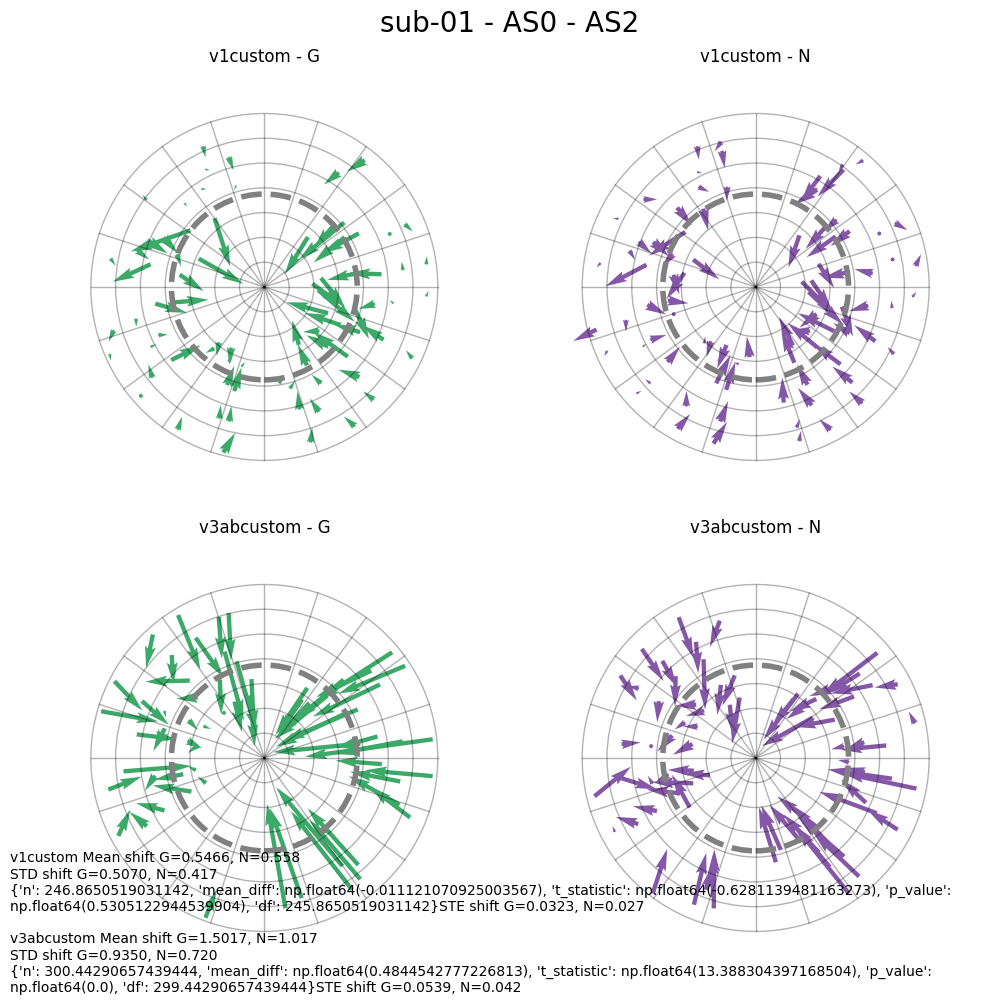

In [33]:
# EVERYTHING 
%matplotlib inline
min_rsq = 0.3
max_ecc = 5
min_vx = 100
sub = 'sub-01'
task1 = 'AS0'
task2 = 'AS2'
fig, axs = plt.subplots(2,2, figsize=(10,10))
fig.suptitle(f'{sub} - {task1} - {task2}', fontsize=20)

full_ecc_bounds =  np.linspace(0, 4, 5)
full_pol_bounds = np.linspace(-np.pi, np.pi, 13)

v_rois = ['v1custom', 'v3abcustom']
v_models = ['G', 'N']
arrow_bin_kwargs = dict(
    do_binning=True, 
    ecc_bounds = np.linspace(0, 4, 8),
    pol_bounds = np.linspace(-np.pi, np.pi, 21),
    min_vx_per_bin=min_vx, 
)
scat_options = dict(
    do_arrows=True, 
    do_scatter = False,
)
from dag_prf_utils.stats import dag_paired_ttest
ctext_note = ''
for iR,roi in enumerate(v_rois):
    for iM,model in enumerate(v_models):
        ax = axs[iR,iM]

        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
        th = {
            
            f'{task1}f_{model}-min-rsq': min_rsq,
            f'{task2}f_{model}-min-rsq': min_rsq,
            f'{task1}f_{model}-max-ecc': max_ecc,
            f'{task2}f_{model}-max-ecc': max_ecc,
            'roi' : get_roi(sub, roi, combine_matches=True),
        }
        prf_obj[sub].arrow(
            ax = ax,
            pold=f'{task1}f_{model}',
            pnew=f'{task2}f_{model}',         
            th=th,
            dot_size=25,
            old_col = 'k',
            new_col = 'r',
            dot_alpha=1,
            arrow_col=mod_cols[model],
            **scat_options,
            **arrow_bin_kwargs,
            arrow_headwidth = 2.5
        )
        scot_patch = mpl.patches.Circle(
            scotoma_info[f'task-{task2}']['scotoma_centre'], 
            scotoma_info[f'task-{task2}']['scotoma_radius'], 
            color='grey', linewidth=4, 
            fill=False, alpha=1,
            linestyle='--', 
            label='Scotoma'
            )
        
        ax.add_patch(scot_patch)
        ax.set_title(f'{roi} - {model}')

    # **** Add info about the mean, STD, and t testing...
    th = {        
        f'{task1}f_G-min-rsq': 0.1,
        f'{task2}f_G-min-rsq': 0.1,
        f'{task1}f_G-max-ecc': max_ecc,
        f'{task2}f_G-max-ecc': max_ecc,
        f'{task1}f_N-min-rsq': 0.1,
        f'{task2}f_N-min-rsq': 0.1,
        f'{task1}f_N-max-ecc': max_ecc,
        f'{task2}f_N-max-ecc': max_ecc,        
        'roi' : get_roi(sub, roi, combine_matches=True),
    }    
    vx_mask  = prf_obj[sub].return_vx_mask(th)
    vx_mask &= get_roi(sub, roi, combine_matches=True) # ALL                 
    print(vx_mask.sum())
    if vx_mask.sum()<min_vx:
        # print(f'failed to get {roi} for {sub}')        
        continue
    shift1s = prf_obj[sub].return_diff_params(
        f'{task1}f_G', f'{task2}f_G', 'shift_mag')['shift_mag'][vx_mask].to_numpy()
    shift2s = prf_obj[sub].return_diff_params(
        f'{task1}f_N', f'{task2}f_N', 'shift_mag')['shift_mag'][vx_mask].to_numpy()        
    diff_stats = dag_paired_ttest(shift1s, shift2s, upsampling_factor=upsampling_factor)
    print(f'')
    print(f'{roi}')
    print(f'Mean shift G={np.mean(shift1s):.4f}, N={np.mean(shift2s):.3f}')
    print(f'STD shift G={np.std(shift1s):.4f}, N={np.std(shift2s):.3f}')        
    print(diff_stats)
    print(f'STE shift G={np.std(shift1s)/np.sqrt(diff_stats["n"]):.4f}, N={np.std(shift2s)/np.sqrt(diff_stats["n"]):.3f}')        
    # bloop
    ctext_note += f'\n\n{roi} ' + \
        f'Mean shift G={np.mean(shift1s):.4f}, N={np.mean(shift2s):.3f}\n' + \
        f'STD shift G={np.std(shift1s):.4f}, N={np.std(shift2s):.3f}\n' + \
        f'{diff_stats}' + \
        f'STE shift G={np.std(shift1s)/np.sqrt(diff_stats["n"]):.4f}, N={np.std(shift2s)/np.sqrt(diff_stats["n"]):.3f}'
        



        # ***
plt.tight_layout()
fig_saver.add_img(
    fig=plt.gcf(),
    fig_name=f'vector_plot{sub}_{task1}_{task2}',
    context_note=ctext_note,
)

In [ ]:
prf_obj['sub-01']

['AS0f_G', 'AS0f_N', 'AS1f_G', 'AS1f_N', 'AS2f_G', 'AS2f_N']

# Paired bar

In [17]:
from dag_prf_utils.stats import dag_paired_ttest
def PAIRED_df(prf_obj, roi_list, p1diff, p2diff, diff_ids,  **kwargs):
    # HOW THRESH...
    # only_close_to_scot = kwargs.get('only_close_to_scot', False)
    min_rsq = kwargs.get('min_rsq', 0.1)
    max_ecc = kwargs.get('max_ecc', 5)
    min_vx = kwargs.get('min_vx', 50)

    sub_list = list(prf_obj.keys())
    nice_roi_list = [i.split('custom')[0] for i in roi_list]

    # Create threshold dictionary    
    th = {}
    for th_key in [*p1diff, *p2diff]:
        th[f'{th_key}-min-rsq'] = min_rsq
        th[f'{th_key}-max-ecc'] = max_ecc    
    # if only_close_to_scot:
    #     th[f'AS0_gauss-min-d2s_{only_close_to_scot}'] = scotoma_info[f'task-{only_close_to_scot}']['scotoma_radius'] + 1
    
    # Difference
    diff_dict = {
        'sub' : [],
        'roi' : [],
        'condition' : [],
        'shift' : [],
    }
    diff_stats = {}
    for iS,sub in enumerate(sub_list):
        diff_stats[sub] = {}
        vx_mask  = prf_obj[sub].return_vx_mask(th)
        for iR, roi in enumerate(roi_list):
            nice_roi = nice_roi_list[iR]
            vx_mask  = prf_obj[sub].return_vx_mask(th)
            vx_mask &= get_roi(sub, roi, combine_matches=True) # ALL                 
            if vx_mask.sum()<min_vx:
                # print(f'failed to get {roi} for {sub}')        
                continue
            shift1s = prf_obj[sub].return_diff_params(
                p1diff[0], p1diff[1], 'shift_mag')['shift_mag'][vx_mask].to_numpy()
            shift1 = np.median(shift1s)
            shift2s = prf_obj[sub].return_diff_params(
                p2diff[0], p2diff[1], 'shift_mag')['shift_mag'][vx_mask].to_numpy()
            shift2 = np.median(shift2s)

            # Do the stats
            diff_stats[sub][nice_roi] = dag_paired_ttest(shift1s, shift2s, upsampling_factor=upsampling_factor)
            # shift 1
            diff_dict['sub'].append(sub)
            diff_dict['roi'].append(nice_roi)
            diff_dict['condition'].append(diff_ids[0])
            diff_dict['shift'].append(shift1)
            # shift 2
            diff_dict['sub'].append(sub)
            diff_dict['roi'].append(nice_roi)
            diff_dict['condition'].append(diff_ids[1])
            diff_dict['shift'].append(shift2)
            
    df = pd.DataFrame(diff_dict)
    return df, diff_stats


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def SCOT_paired_bar_plot(df, diff_stats, fig, ax, nice_roi_list, mod_cols):
    
    # Calculate medians
    rois = df['roi'].unique()
    roi_medians = {'gauss':[], 'norm':[]}
    for condition in ['gauss', 'norm']:
        for roi in rois:
            roi_data = df[(df['roi'] == roi) & (df['condition'] == condition)]['shift']
            roi_medians[condition].append(roi_data.mean())

    # Plotting the median bars
    width = 0.35
    bar_positions = np.arange(len(rois))

    for i, condition in enumerate(['gauss', 'norm']):
        bar_offset = width * i
        ax.bar(bar_positions + bar_offset, roi_medians[condition], width=width, label=condition, color=mod_cols[condition])

    # Plotting the individual participant lines
    participants = df['sub'].unique()
    sub_cols = plt.cm.tab20(np.linspace(0, 1, len(participants)))
    for iS,participant in enumerate(participants):
        for iR,roi in enumerate(rois):
            gauss_value = df[(df['sub'] == participant) & (df['roi'] == roi) & (df['condition'] == 'gauss')]['shift'] #.values[0]
            norm_value = df[(df['sub'] == participant) & (df['roi'] == roi) & (df['condition'] == 'norm')]['shift'] # .values[0]
            # if len(gauss_value) == 0:
            #     gauss_value = np.NaN
            # else:
            #     gauss_value = gauss_value.values[0]
            # if len(norm_value) == 0:
            #     norm_value = np.NaN
            # else:
            #     norm_value = norm_value.values[0]
            if len(gauss_value) == 0:
                continue
            if diff_stats[participant][roi]['p_value'] > 0.01:
                lkwargs = {
                    'alpha' : 0.8,
                    'linestyle' : '--',
                    'marker' : 'o',
                    'mfc' : 'none',
                    'markersize' : 4,
                }
            else:
                lkwargs = {
                    'alpha' : 1,
                    'linestyle' : '-',
                    'marker' : 'x',
                    'markersize' : 5,
                }
            x_values = [bar_positions[iR] , bar_positions[iR] + width]            
            y_values = [gauss_value, norm_value]
            # PRINT THE STUFF TOO!
            print(f'{participant} - {roi} - gshift={gauss_value.values[0]:.9f} - nshift={norm_value.values[0]:.9f}')
            ax.plot(x_values, y_values, 
                    color='grey', # sub_cols[iS], # 'grey', 
                    **lkwargs,
                    # label=participant if iR == 0 else None
                    )

            # ax.plot([day - 1 + width/2, day - 1 + 1.5 * width], [fun_value, not_fun_value], color='grey', alpha=0.5, marker='o')
            # ax.plot(day - 1 + width/2, fun_value, 'o', color='red')
            # ax.plot(day - 1 + 1.5 * width, not_fun_value, 'o', color='blue')

    # Customize plot
    ax.set_xticks(bar_positions + width / 2)
    ax.set_xticklabels(nice_roi_list)
    ax.set_ylim([0, 2.25])
    ax.set_xlabel('ROI')
    ax.set_ylabel('Shift magnitude (degrees)')
    ax.set_title('')
    ax.legend(title='Model')
    sns.despine()
    # plt.show()
    return fig,ax


def SCOT_diff_bar_plot(df, diff_stats, fig, ax, nice_roi_list, mod_cols):

    # Calculate medians
    rois = df['roi'].unique()
    roi_medians = []
    for roi in rois:
        mdata = []
        for condition in ['gauss', 'norm']:
            roi_data = df[(df['roi'] == roi) & (df['condition'] == condition)]['shift']
            mdata.append(roi_data.mean())
        roi_medians.append(mdata[0] - mdata[1])

    # Plotting the median bars
    width = 0.35 * 2
    bar_positions = np.arange(len(rois))
    ax.bar(bar_positions, roi_medians, width=width, color='#fdbb84') # label=condition, color=mod_cols[condition])

    # Plotting the individual participant lines
    participants = df['sub'].unique()
    sub_cols = plt.cm.tab20(np.linspace(0, 1, len(participants)))
    for iS,participant in enumerate(participants):
        for iR,roi in enumerate(rois):
            gauss_value = df[(df['sub'] == participant) & (df['roi'] == roi) & (df['condition'] == 'gauss')]['shift'].to_numpy() #.values[0]
            norm_value = df[(df['sub'] == participant) & (df['roi'] == roi) & (df['condition'] == 'norm')]['shift'].to_numpy() # .values[0]            
            if len(gauss_value) == 0:
                continue
                                
            diff_value = gauss_value.copy() - norm_value.copy()
            if diff_stats[participant][roi]['p_value'] > 0.01:
                lkwargs = {
                    'alpha' : 0.8,
                    'marker' : 'o',
                    'facecolors' : 'none',
                    's' : 15,
                }
            else:
                lkwargs = {
                    'alpha' : 1,
                    'marker' : 'x',
                    's' : 20,
                }
            ax.scatter(
                bar_positions[iR], diff_value, 
                color='grey', 
                **lkwargs,
                )

            # ax.plot([day - 1 + width/2, day - 1 + 1.5 * width], [fun_value, not_fun_value], color='grey', alpha=0.5, marker='o')
            # ax.plot(day - 1 + width/2, fun_value, 'o', color='red')
            # ax.plot(day - 1 + 1.5 * width, not_fun_value, 'o', color='blue')

    # Customize plot
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(nice_roi_list)
    sns.despine()
    ax.set_ylim([-.2, 1])
    ax.set_yticks([-.2, 0, .2, .4, .6, .8, 1])
    xlim = ax.get_xlim()
    ax.hlines(0, -1, len(rois), linestyle='--', alpha=.5)
    ax.set_xlim(xlim)
    
    # ax.set_xlabel('ROI')
    # ax.set_ylabel('Shift magnitude (degrees)')
    # ax.set_title('')
    # ax.legend(title='Model')

    # plt.show()
    return fig,ax


#### Across ROIs


TASK!! AS1
sub-01 - v1 - gshift=0.229094661 - nshift=0.228718651
sub-01 - v2 - gshift=0.294437562 - nshift=0.285917093
sub-01 - v3 - gshift=0.253249456 - nshift=0.250456844
sub-01 - v3ab - gshift=0.696060795 - nshift=0.493014659
sub-01 - v4 - gshift=0.522268480 - nshift=0.451495399
sub-01 - LO - gshift=0.520365671 - nshift=0.480591546
sub-01 - TO - gshift=1.355033559 - nshift=0.875700448
sub-01 - IPS - gshift=1.002134589 - nshift=0.853083154
sub-02 - v1 - gshift=0.284829276 - nshift=0.289124027
sub-02 - v2 - gshift=0.364588478 - nshift=0.362996568
sub-02 - v3 - gshift=0.408230608 - nshift=0.406270018
sub-02 - v3ab - gshift=0.730120406 - nshift=0.650140739
sub-02 - v4 - gshift=0.540870896 - nshift=0.536332147
sub-02 - LO - gshift=0.514199155 - nshift=0.472569611
sub-02 - TO - gshift=1.329881301 - nshift=1.095243637
sub-02 - IPS - gshift=0.870238279 - nshift=0.865832519
sub-03 - v1 - gshift=0.277063927 - nshift=0.279256383
sub-03 - v2 - gshift=0.326069807 - nshift=0.303991202
sub-03 - v

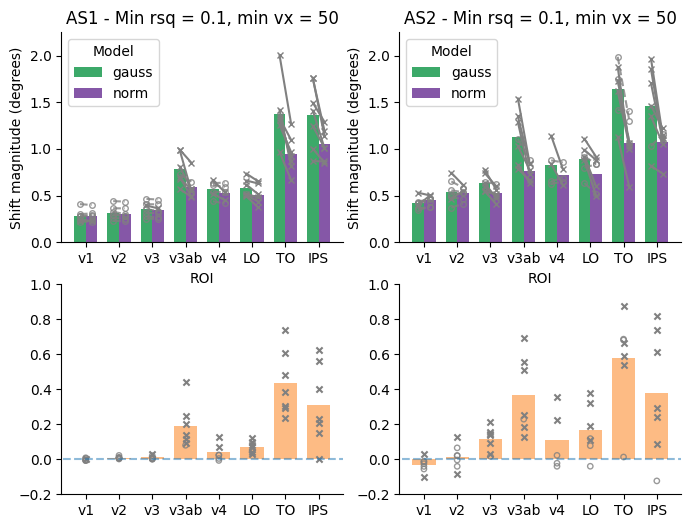

In [21]:
%matplotlib inline
min_rsq = 0.1
min_vx = 50
max_ecc = 5

fig, axs = plt.subplots(2, 2, figsize=(8,6))
for iT,task in enumerate(['AS1', 'AS2']):    
    print('')
    print(f'TASK!! {task}')
    df, diff_stats = PAIRED_df(
        prf_obj=prf_obj,
        roi_list=roi_list[1::],
        min_rsq=min_rsq,
        max_ecc=max_ecc,
        min_vx = min_vx,
        p1diff=['AS0f_G',    f'{task}f_G'],
        p2diff=['AS0f_N',    f'{task}f_N'],
        diff_ids = ['gauss', 'norm'],
    )
    ax = axs[0,iT]
    fig, ax = SCOT_paired_bar_plot(
        df=df, diff_stats=diff_stats, fig=fig, ax=ax,
        nice_roi_list=[i.split('custom')[0] for i in roi_list[1::]],
        mod_cols=mod_cols
        )
    ax.set_title(f'{task} - Min rsq = {min_rsq}, min vx = {min_vx}')
    ax = axs[1,iT]
    fig, ax = SCOT_diff_bar_plot(
        df=df, diff_stats=diff_stats, fig=fig, ax=ax,
        nice_roi_list=[i.split('custom')[0] for i in roi_list[1::]],
        mod_cols=mod_cols
        )
    
    # ax.set_title(f'{task} - Min rsq = {min_rsq}, min vx = {min_vx}')
    # ax.set_ylim([0, 2])
    # sns.despine()

    # Difference plot

fig_saver.add_img(
    fig, f'paired_bar_plot',
)    

# SAVE

In [ ]:
save_running_code(fig_saver.path)